# Notes

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 19 20:10:52 2021

Metabolic Stability and Epigenesis in Randomly Constructed Genetic Nets by Stuart 
Kauffman, Journal of Theoretical Biology (1969) vol 22, 437-467


Random (uniform) values of p and K for each iteration.

Take mean over all agent states at T = 20.

Use GP regression to infer response between (p,K) and < x_20 >

@author: bruce
"""

'\nCreated on Tue Jan 19 20:10:52 2021\n\nMetabolic Stability and Epigenesis in Randomly Constructed Genetic Nets by Stuart \nKauffman, Journal of Theoretical Biology (1969) vol 22, 437-467\n\n\nRandom (uniform) values of p and K for each iteration.\n\nTake mean over all agent states at T = 20.\n\nUse GP regression to infer response between (p,K) and < x_20 >\n\n@author: bruce\n'

## Imports

In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from tqdm import trange

import matplotlib
import matplotlib.pyplot as plt
import pymc3 as pm

import time

## ABM simulation

In [3]:
start_time = time.time()

PLOT_GATE = True

######################################
######################################
# fixed population parameters
######################################

N = 1000 # number of "genes" or agents or nodes
T = 20#time steps

# free parameters ######################################

# two parameters: k and p
# chosen uniformly at random from following intervals
K = [1, 16] # [K_min, K_max]
# p uniform on [0,1)

# expected number of 1's in initial conditions
# x_0 random, defined inside parameter loop

# number of iterations / samples
nIter = 30
#####################################

#Got seed ? 
#np.random.seed(718281828)

#####################################################
# ABM function
######################################################

def kaufNetABM(N,x_0,K,p,T):
    stateMean = np.array([])
    #choose influencers for each node
    edgeList = []
    for agent in range(N):
        k = K
        #k = np.random.poisson(K-1)+1
        edgeList = edgeList + [np.random.choice(N,k,replace=False)]
        
    #state vector
    X = np.zeros((T+1,N))
    #set initial conditions
    initialConditions = np.random.binomial(1,x_0,N)
    X[0,] = initialConditions   
        
    stateMean = np.append(stateMean,X[0,].mean())
        
    #random logic for each agent
    # each agent assigned a random map, agentMap (dictionary)
    # maps are indexed in a (list), mapList
    # there are 2**K possible inputs, and a p-coin is flipped to determine the value at each input
    mapList = []
    for agent in range(N):
        agentMap = {}
        for key in range(2**K):
            agentMap[key] = np.random.binomial(1,p)
        mapList = mapList + [agentMap]
        
    #dynamics
    for t in range(T):
        for agent in range(N):
       #base 2 representation of inputs, to match encodeing in dictionary 
            mapKey = 0
            for k in range(K):     
                mapKey = mapKey + (2**k)*X[t,edgeList[agent][k]]
            X[t+1,agent] = mapList[agent][mapKey]
        
        #record stats
        stateMean = np.append(stateMean, X[t+1,].mean())
    return(stateMean[T])

######################################################### end ABM function

# Data ####################
output = []
###############################


################################
# Iterating ABM over parameters
################################


for iter in trange(nIter):
    x_0 = np.random.rand()
    k = np.random.randint(K[0],K[1])
    p = np.random.rand()
    stateMean = kaufNetABM(N,x_0,k,p,T)
    output.append([p,k,stateMean])

            
print("---  ABM sims: %s seconds ---" % (time.time() - start_time))

100%|██████████| 30/30 [04:27<00:00,  8.90s/it]

---  ABM sims: 267.14289903640747 seconds ---


## GP emulator (PyMC3 & SKL)

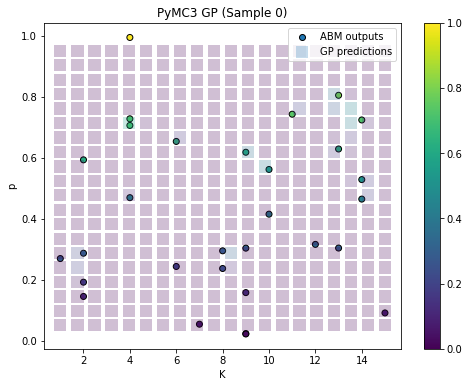

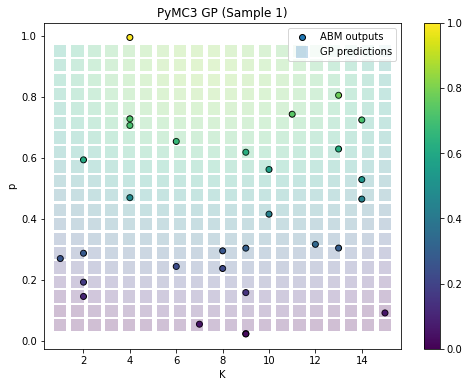

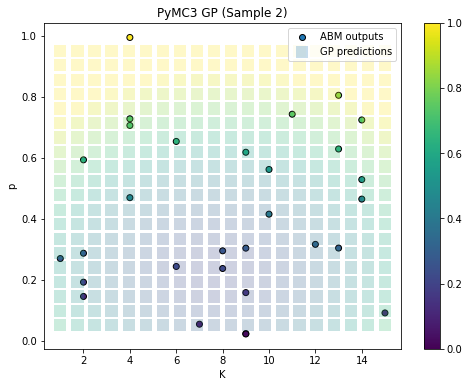

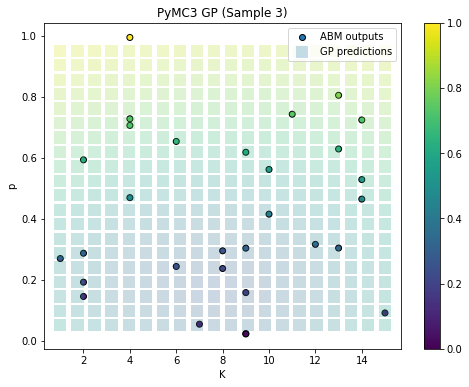

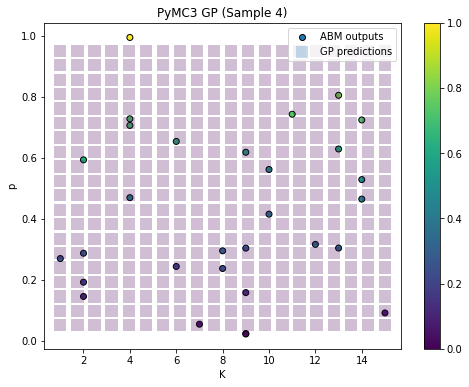

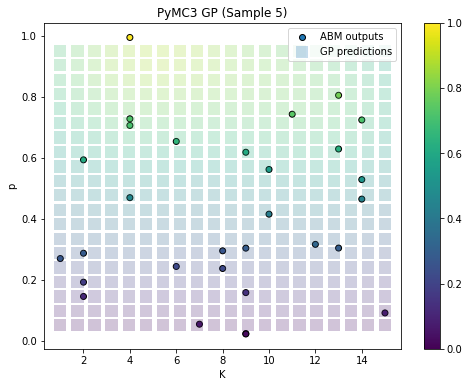

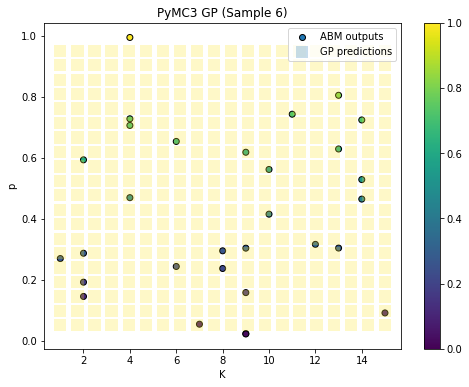

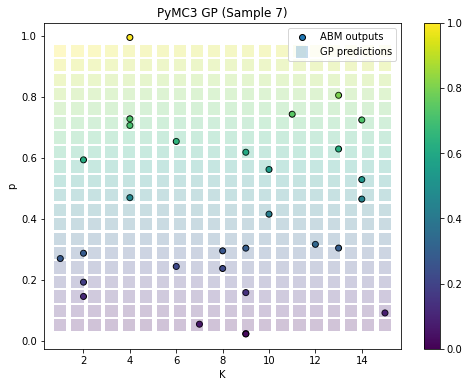

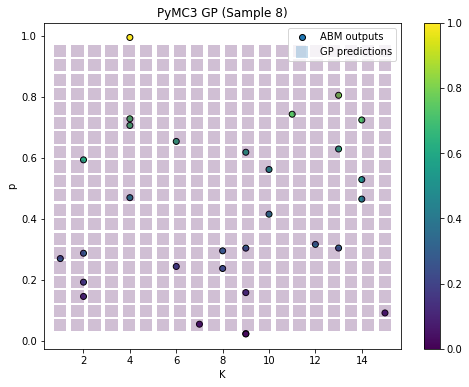

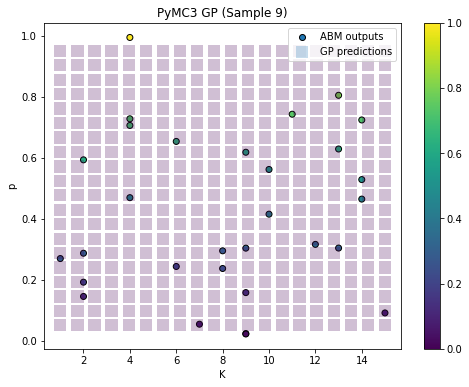

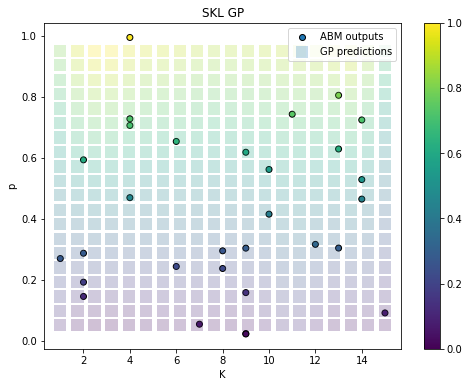

In [100]:
output = np.array(output)
#input into GP model .fit()
# shape = number samples x number parameters 
trainingParams = output[:,:2]
abmOutput = output[:,2]

paramScales = np.std(trainingParams, axis=0)
rescaledParams = trainingParams / paramScales

# # Kp grid points
nPred = 20
pPlot = np.linspace(0.05,0.95,num = nPred)
kPlot = np.linspace(1,15,num = nPred)

predParams = np.stack([x.ravel() for x in np.meshgrid(pPlot,kPlot)], axis=1)

n_samples_pymc3 = 10
y_pred_pymc3 = np.zeros([n_samples_pymc3,predParams.shape[0]])
# Fit a model in PyMC3

with pm.Model() as model:
    mu = pm.Normal('mu', sd=2)
    mean = pm.gp.mean.Constant(mu)
    
    ls    = pm.Uniform('ls', lower=0.1, upper=5.0)
    scale = pm.HalfCauchy('scale', beta=1.)
    cov   = pm.gp.cov.Matern52(2, ls=ls, active_dims=[0,1]) * scale
    
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)
    sigma = pm.HalfCauchy("sigma", beta=1)
    y = gp.marginal_likelihood('y', X=rescaledParams, y=abmOutput, noise=sigma)
    trace = pm.sample()
    for i in range(n_samples_pymc3):
        yp, sigma = gp.predict(predParams/paramScales)
        y_pred_pymc3[i] = yp
    
#Instantiate a GP model in SKLearn
kernel = ConstantKernel(constant_value = 0.5, constant_value_bounds = (0.1,4))*RBF(length_scale = 0.5,length_scale_bounds =(1e-2,5)) 
#kernel = ConstantKernel(0.5, (1e-2,1))+RBF(2,(1e-1,10))
gp = GaussianProcessRegressor(kernel = kernel,n_restarts_optimizer = 10, alpha = 0.01,normalize_y = True)
gp.fit(trainingParams,abmOutput)
y_pred_skl, _ = gp.predict(predParams,return_std = True)   

for j in range(n_samples_pymc3):
    plt.figure(figsize=(8,6))
    plt.title('PyMC3 GP (Sample {0})'.format(j))
    plt.scatter(trainingParams[:, 1], trainingParams[:, 0], c=abmOutput,
                label='ABM outputs', edgecolor='k', vmin=0., vmax=1.), plt.colorbar()
    plt.scatter(predParams[:,1], predParams[:, 0], marker='s', alpha=0.25, c=y_pred_pymc3[j],
                s=150, edgecolor='None', label='GP predictions', vmin=0., vmax=1.)
    plt.ylabel('p'), plt.xlabel('K'), plt.legend();
    

plt.figure(figsize=(8,6))
plt.title('SKL GP')
plt.scatter(trainingParams[:, 1], trainingParams[:, 0], c=abmOutput,
            label='ABM outputs', edgecolor='k', vmin=0., vmax=1.), plt.colorbar()
plt.scatter(predParams[:,1], predParams[:, 0], marker='s', alpha=0.25, c=y_pred_skl,
            s=150, edgecolor='None', label='GP predictions', vmin=0., vmax=1.)
plt.ylabel('p'), plt.xlabel('K'), plt.legend();
